# Calisthenics AI Personal Trainer
## Training ML-Models for Handstand, Front Lever & Planche

---
### Importing Modules

In [157]:
# Importing core modules
import numpy as np
import pandas as pd 
import os
import csv
import tqdm 
import sys
import random
import shutil
import tempfile
import cv2
import itertools

# Matplotlib imports
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

# Sklearn modules for model analytics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Importing TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

# Importing MoveNet
movenet_path = os.path.join(os.getcwd(), 'TF-Movenet/examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(movenet_path)

# Load MoveNet Thunder Model and Utlility Classes/Functions
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('./TF-Movenet/movenet_thunder')

---
### Initialising Paths

In [158]:
# Initialising key paths for each calisthenics movement to iterate through and store certain data
PATH_DICT = {
    "Front Lever": {
        "DATASET_IN": "./Input/Front Lever/",
        "DATASET_OUT": "./Input/Split-Front Lever/",
        "OUTPUT_DIR": "./TF-Models/Front Lever/Data/",
        "CLASSIFIER": "./TF-Models/Front Lever/Front Lever-Classifier.tflite",
        "LABELS": "./TF-Models/Front Lever/Front Lever-Labels.txt"
    },

    "Handstand": {
        "DATASET_IN": "./Input/Handstand/",
        "DATASET_OUT": "./Input/Split-Handstand/",
        "OUTPUT_DIR": "./TF-Models/Handstand/Data/",
        "CLASSIFIER": "./TF-Models/Handstand/Handstand-Classifier.tflite",
        "LABELS": "./TF-Models/Handstand/Handstand-Labels.txt"
    },

    "Planche": {
        "DATASET_IN": "./Input/Planche/",
        "DATASET_OUT": "./Input/Split-Planche/",
        "OUTPUT_DIR": "./TF-Models/Planche/Data/",
        "CLASSIFIER": "./TF-Models/Planche/Planche-Classifier.tflite",
        "LABELS": "./TF-Models/Planche/Planche-Labels.txt"
    }
}

---
#### Removing Pre-Existing Directories and Files

In [159]:
# List of paths to check and delete if they already exist
# These are the paths where new data will be stored and so they must be removed before adding new data
PATH_LIST = [
    "./Input/Split-Front Lever",
    "./TF-Models/Front Lever/Data",
    "./TF-Models/Front Lever/Front Lever-Classifier.tflite",
    "./TF-Models/Front Lever/Front Lever-Labels.txt",
    "./TF-Models/Front Lever/weights.best.hdf5",
    "./Input/Split-Handstand",
    "./TF-Models/Handstand/Data",
    "./TF-Models/Handstand/Handstand-Classifier.tflite",
    "./TF-Models/Handstand/Handstand-Labels.txt",
    "./TF-Models/Handstand/weights.best.hdf5",
    "./Input/Split-Planche",
    "./TF-Models/Planche/Data",
    "./TF-Models/Planche/Planche-Classifier.tflite",
    "./TF-Models/Planche/Planche-Labels.txt",
    "./TF-Models/Planche/weights.best.hdf5"
]

# Iterate through the paths
for path in PATH_LIST:

    if os.path.exists(path):

        # If the path is a file, delete the file
        if os.path.isfile(path):
            try:
                os.remove(path)
                print(f"File '{path}' deleted successfully.")
            except OSError as e:
                print(f"Error deleting file '{path}': {e}")

        # If the path is a directory, delete the directory and its contents
        elif os.path.isdir(path):
            try:
                shutil.rmtree(path)
                print(f"Directory '{path}' and its contents deleted successfully.")
            except OSError as e:
                print(f"Error deleting directory '{path}': {e}")
                
    else:
        print(f"Path '{path}' does not exist.")

Directory './Input/Split-Front Lever' and its contents deleted successfully.
Directory './TF-Models/Front Lever/Data' and its contents deleted successfully.
File './TF-Models/Front Lever/Front Lever-Classifier.tflite' deleted successfully.
File './TF-Models/Front Lever/Front Lever-Labels.txt' deleted successfully.
File './TF-Models/Front Lever/weights.best.hdf5' deleted successfully.
Directory './Input/Split-Handstand' and its contents deleted successfully.
Directory './TF-Models/Handstand/Data' and its contents deleted successfully.
File './TF-Models/Handstand/Handstand-Classifier.tflite' deleted successfully.
File './TF-Models/Handstand/Handstand-Labels.txt' deleted successfully.
File './TF-Models/Handstand/weights.best.hdf5' deleted successfully.
Directory './Input/Split-Planche' and its contents deleted successfully.
Directory './TF-Models/Planche/Data' and its contents deleted successfully.
File './TF-Models/Planche/Planche-Classifier.tflite' deleted successfully.
File './TF-Model

---
### Pre-processing

In [160]:
# Runs detection on an input image
def detect(input_tensor, inference_count=3):
    # Perform the first inference with reset_crop_region set to True
    movenet.detect(input_tensor.numpy(), reset_crop_region=True)
    
    # Perform subsequent inferences (inference_count - 1 times) with reset_crop_region set to False,
    # reusing the crop region computed in the first inference
    for _ in range(inference_count - 1):
        detection = movenet.detect(input_tensor.numpy(), reset_crop_region=False)
    
    # Return the detection result from the last inference
    return detection

In [161]:
# Draw the extracted pose result on top of a white box
def draw_pose(image, person):
  # create a numpy array filled with 255 (white)
  image = np.full(image.shape, 255, dtype=np.uint8)

  # set the values within the box to 255 (white)
  image[1:-1, 1:-1] = 255

  # Visualise the pose on the white box image and return it
  image_np = utils.visualize(image, [person])
  return image_np

In [162]:
# Class to pre-process data
class MoveNetPreprocessor(object):
 
  def __init__(self, images_in_folder, images_out_folder, csvs_out_path):
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):

    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path + '. Image isn\'t in RGB format.')
            continue

          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path + '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_pose(image.numpy().astype(np.uint8), person)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [163]:
# Split Directory into Train and Test Images
def split_into_train_test(images_origin, images_dest, test_split):
    _, dirs, _ = next(os.walk(images_origin))

    TRAIN_DIR = os.path.join(images_dest, 'train')
    TEST_DIR = os.path.join(images_dest, 'test')
    os.makedirs(TRAIN_DIR, exist_ok=True)
    os.makedirs(TEST_DIR, exist_ok=True)

    for dir in dirs:
        # Get all filenames for this dir, filtered by filetype
        filenames = os.listdir(os.path.join(images_origin, dir))
        filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
            f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]

        # Shuffle the files, deterministically
        filenames.sort()
        random.seed(42)
        random.shuffle(filenames)

        # Divide them into train/test dirs
        os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
        os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
        test_count = int(len(filenames) * test_split)
        for i, file in enumerate(filenames):
            if i < test_count:
                destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
            else:
                destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
            shutil.copyfile(file, destination)

        print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')

    print(f'Your split dataset is in "{images_dest}"')

In [164]:
# Preprocess Train Folder
def preprocess_train(IMAGES_ROOT, output_dir):
    images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
    images_out_train_folder = output_dir + '/images_out_train'
    csvs_out_train_path = output_dir + '/train_data.csv'

    preprocessor = MoveNetPreprocessor(
        images_in_folder=images_in_train_folder,
        images_out_folder=images_out_train_folder,
        csvs_out_path=csvs_out_train_path,
    )
    preprocessor.process(per_pose_class_limit=None)

    return images_in_train_folder, images_out_train_folder, csvs_out_train_path

In [165]:
# Preprocess Test Folder
def preprocess_test(IMAGES_ROOT, output_dir):
    images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
    images_out_test_folder = output_dir + '/images_out_test'
    csvs_out_test_path = output_dir + '/test_data.csv'

    preprocessor = MoveNetPreprocessor(
        images_in_folder=images_in_test_folder,
        images_out_folder=images_out_test_folder,
        csvs_out_path=csvs_out_test_path,
    )
    preprocessor.process(per_pose_class_limit=None)

    return images_in_test_folder, images_out_test_folder, csvs_out_test_path

In [166]:
# Iterate through 3 different calisthenics exercises to run splitting for each calisthenics exercise
for key, value in PATH_DICT.items():
    # Split into train and test directories
    split_into_train_test(value["DATASET_IN"], value["DATASET_OUT"], test_split=0.2)

    # Preprocess Train and Test Folders
    images_in_train_folder, images_out_train_folder, csvs_out_train_path = preprocess_train(value["DATASET_OUT"], value["OUTPUT_DIR"])
    images_in_test_folder, images_out_test_folder, csvs_out_test_path = preprocess_test(value["DATASET_OUT"], value["OUTPUT_DIR"])

    # Update PATH_DICT for current calisthenics skill
    PATH_DICT[key].update({
        "images_in_train_folder": images_in_train_folder,
        "images_out_train_folder": images_out_train_folder,
        "csvs_out_train_path": csvs_out_train_path,
        "images_in_test_folder": images_in_test_folder,
        "images_out_test_folder": images_out_test_folder,
        "csvs_out_test_path": csvs_out_test_path
    })

Moved 24 of 120 from class "Perfect" into test.
Moved 1 of 6 from class "Bad" into test.
Moved 18 of 90 from class "Good" into test.


Preprocessing Average


Moved 16 of 84 from class "Average" into test.
Your split dataset is in "./Input/Split-Front Lever/"


  0%|          | 0/68 [00:00<?, ?it/s]/var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/ipykernel_14050/3185874474.py:90: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
100%|██████████| 68/68 [00:37<00:00,  1.80it/s]
Preprocessing Bad
100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
Preprocessing Good
100%|██████████| 72/72 [00:41<00:00,  1.72it/s]
Preprocessing Perfect
100%|██████████| 96/96 [00:57<00:00,  1.66it/s]
Preprocessing Average


Skipped ./Input/Split-Front Lever/train/Average/19.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Front Lever/train/Average/23.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Front Lever/train/Good/33.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Front Lever/train/Good/34.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Front Lever/train/Good/35.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Front Lever/train/Good/58.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Front Lever/train/Good/78.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Front Lever/train/Good/80.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Front Lever/train/Good/81.jpeg. No pose was confidentlly detected.


100%|██████████| 16/16 [00:11<00:00,  1.39it/s]
Preprocessing Bad
100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
Preprocessing Good
100%|██████████| 18/18 [00:08<00:00,  2.04it/s]
Preprocessing Perfect
100%|██████████| 24/24 [00:12<00:00,  1.89it/s]


Skipped ./Input/Split-Front Lever/test/Average/22.jpeg. No pose was confidentlly detected.
Moved 10 of 54 from class "Perfect" into test.
Moved 40 of 204 from class "Bad" into test.
Moved 19 of 96 from class "Good" into test.


Preprocessing Average


Moved 40 of 204 from class "Average" into test.
Your split dataset is in "./Input/Split-Handstand/"


100%|██████████| 164/164 [02:02<00:00,  1.34it/s]
Preprocessing Bad
100%|██████████| 164/164 [01:17<00:00,  2.12it/s]
Preprocessing Good
100%|██████████| 77/77 [02:10<00:00,  1.70s/it]
Preprocessing Perfect
100%|██████████| 44/44 [00:52<00:00,  1.18s/it]


Skipped ./Input/Split-Handstand/train/Average/101.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/train/Average/156.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/train/Average/157.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/train/Average/62.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/train/Bad/187.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/train/Bad/188.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/train/Bad/19.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/train/Bad/21.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/train/Bad/22.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/train/Bad/23.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/train/Bad/27.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/t

Preprocessing Average
100%|██████████| 40/40 [00:30<00:00,  1.30it/s]
Preprocessing Bad
100%|██████████| 40/40 [00:19<00:00,  2.07it/s]
Preprocessing Good
100%|██████████| 19/19 [00:32<00:00,  1.69s/it]
Preprocessing Perfect
100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Skipped ./Input/Split-Handstand/test/Average/100.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/test/Average/32.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/test/Average/60.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/test/Average/61.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/test/Average/99.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/test/Bad/28.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/test/Bad/48.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/test/Good/108.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Handstand/test/Perfect/70.jpeg. No pose was confidentlly detected.
Moved 20 of 102 from class "Perfect" into test.
Moved 21 of 108 from class "Bad" into test.
Moved 12 of 60 from class "Good" into test.


Preprocessing Average


Moved 39 of 198 from class "Average" into test.
Your split dataset is in "./Input/Split-Planche/"


100%|██████████| 159/159 [01:17<00:00,  2.06it/s]
Preprocessing Bad
100%|██████████| 87/87 [00:42<00:00,  2.06it/s]
Preprocessing Good
100%|██████████| 48/48 [00:23<00:00,  2.03it/s]
Preprocessing Perfect
100%|██████████| 82/82 [00:42<00:00,  1.95it/s]
Preprocessing Average


Skipped ./Input/Split-Planche/train/Average/10.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Average/190.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Average/8.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Average/85.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Average/86.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Average/9.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Bad/32.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Bad/33.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Good/1.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Good/3.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Good/36.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/train/Good/49.jpeg. No

100%|██████████| 39/39 [00:22<00:00,  1.75it/s]
Preprocessing Bad
100%|██████████| 21/21 [00:10<00:00,  1.92it/s]
Preprocessing Good
100%|██████████| 12/12 [00:06<00:00,  1.94it/s]
Preprocessing Perfect
100%|██████████| 20/20 [00:10<00:00,  1.86it/s]

Skipped ./Input/Split-Planche/test/Average/7.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/test/Average/87.jpeg. No pose was confidentlly detected.
Skipped ./Input/Split-Planche/test/Good/4.jpeg. No pose was confidentlly detected.


In [167]:
# Loads a CSV Created by MoveNetPreprocessor
def load_pose_landmarks(csv_path):
    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    classes = df_to_process.pop('class_name').unique()

    # Extract the labels
    y = df_to_process.pop('class_no')

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [168]:
# Calculates Center Point of Two Given Landmarks
def get_center_point(landmarks, left_bodypart, right_bodypart):
  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center

In [169]:
# Calculates Pose Size 
# Maximum of two values 
# - Torso size multiplied by `torso_size_multiplier` 
# - Maximum distance from pose center to any pose landmark
def get_pose_size(landmarks, torso_size_multiplier=2.5):
  
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)

    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new, [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0, name="dist_to_pose_center")

    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size

In [170]:
# Normalizing Landmarks by Moving Pose Center to (0,0) and Scaling to Constant Size
def normalize_pose_landmarks(landmarks):
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)

    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks

In [171]:
# Converts Input Landmarks into Pose Embedding
def landmarks_to_embedding(landmarks_and_scores):

  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [172]:
# Preprocess the given data
def preprocess_data(X):
    processed_X = []
    for i in range(X.shape[0]):
        embedding = landmarks_to_embedding(tf.reshape(tf.convert_to_tensor(X.iloc[i]), (1, 51)))
        processed_X.append(tf.reshape(embedding, (34)))
    return tf.convert_to_tensor(processed_X)

---
### Training

In [173]:
# Iterate through each calisthenics skill
for key, value in PATH_DICT.items():
    csvs_out_train_path = value["csvs_out_train_path"]
    csvs_out_test_path = value["csvs_out_test_path"]

    # Load the train data
    X, y, class_names, df = load_pose_landmarks(csvs_out_train_path)

    # Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

    # Load the test data
    X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

    # Processing the data and creating the model
    processed_X_train = preprocess_data(X_train)
    processed_X_val =  preprocess_data(X_val)
    processed_X_test = preprocess_data(X_test)

    inputs = tf.keras.Input(shape=(34))
    layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
    layer = keras.layers.Dropout(0.5)(layer)
    layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
    layer = keras.layers.Dropout(0.5)(layer)
    outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

    model = keras.Model(inputs, outputs)
    print(model.summary())

    # Compiling the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Add a checkpoint callback to store the checkpoint that has the highest validation accuracy.
    checkpoint_path = "TF-Models/" + key + "/weights.best.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')
    earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                patience=20)

    # Start training
    history = model.fit(processed_X_train, y_train,
                        epochs=200,
                        batch_size=16,
                        validation_data=(processed_X_val, y_val),
                        callbacks=[checkpoint, earlystopping])

    # Updating the PATH_DICT for the current skill
    PATH_DICT[key].update({
        "history": history,
        "model": model,
        "processed_X_test": processed_X_test,
        "y_test": y_test,
        "class_names": class_names,
        "processed_X_test": processed_X_test
    })

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 34)]              0         
                                                                 
 dense_42 (Dense)            (None, 128)               4480      
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_44 (Dense)            (None, 4)                 260       
                                                                 
Total params: 12,996
Trainable params: 12,996
Non-trainabl

---
# Model Evaluation

#### Plotting Accuracy

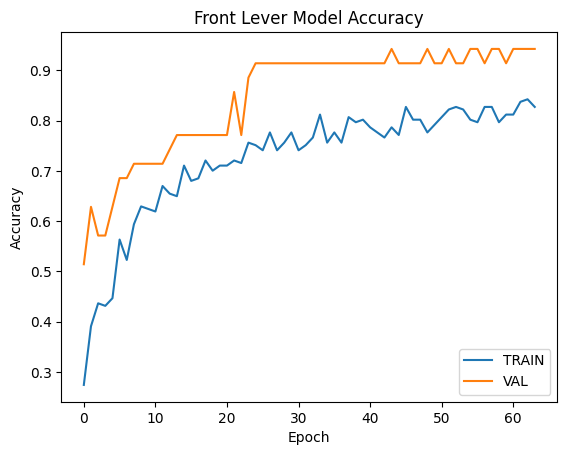

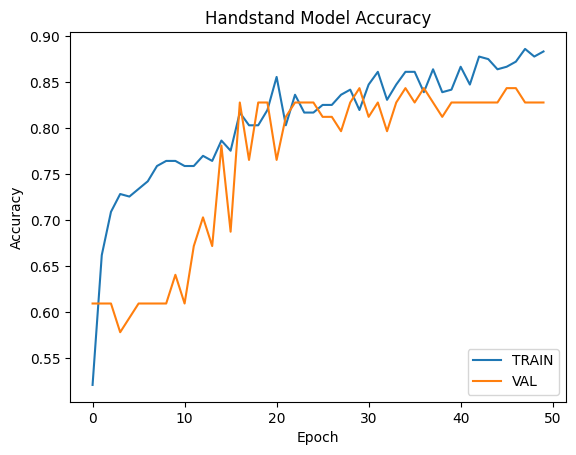

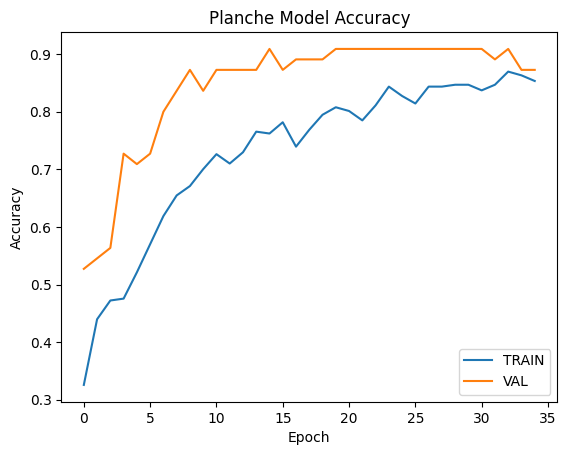

In [174]:
# Visualising the accuracy graph after each epoch for each calisthenics model
for key, value in PATH_DICT.items():
    history = value["history"]

    # Visualize the training history to see whether you're overfitting.
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('{0} Model Accuracy'.format(key))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['TRAIN', 'VAL'], loc='lower right')
    plt.show()

In [175]:
# Iterate through each calisthenics skill and evaluate each model
for key, value in PATH_DICT.items():
    processed_X_test = value["processed_X_test"]
    y_test = value["y_test"]
    model = value["model"]

    # Evaluate the model using the TEST dataset
    print(key + ": ")
    loss, accuracy = model.evaluate(processed_X_test, y_test)

Front Lever: 
2/2 [==============================] - 0s 13ms/step - loss: 0.3704 - accuracy: 0.8448
Handstand: 
4/4 [==============================] - 0s 4ms/step - loss: 0.2388 - accuracy: 0.9100
Planche: 
3/3 [==============================] - 0s 6ms/step - loss: 0.3511 - accuracy: 0.8539


#### Confusion Matrices

In [176]:
# Plotting a confusion matrix to understand if the model is classifying images correctly
# Helps to identify areas where the model is classifying incorrectly
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

2/2 [==============================] - 0s 7ms/step
Confusion matrix, without normalization


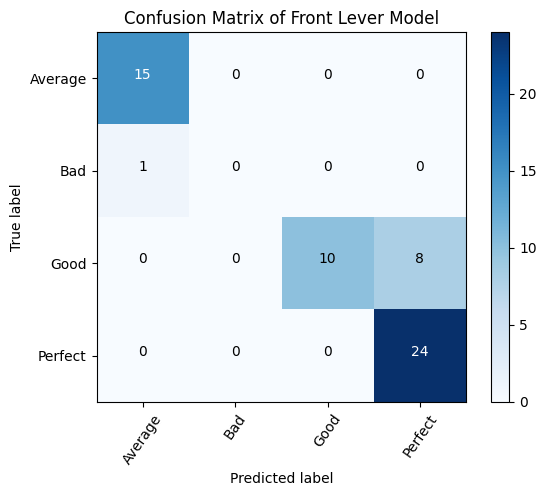

4/4 [==============================] - 0s 2ms/step
Confusion matrix, without normalization


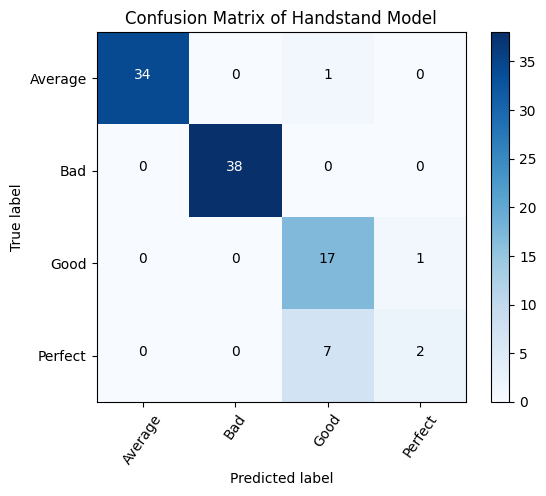

3/3 [==============================] - 0s 5ms/step
Confusion matrix, without normalization


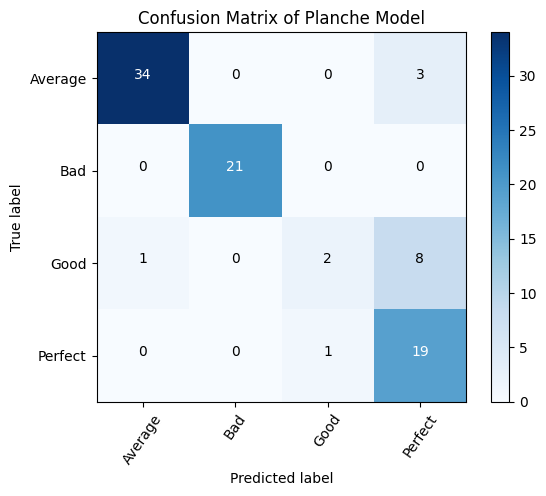

In [177]:
# Iterating through each calisthenics skill and plotting the confusion matrix
for key, value in PATH_DICT.items():
  processed_X_test = value["processed_X_test"]
  y_test = value["y_test"]
  class_names = value["class_names"]
  model = value["model"]

  # Classify pose in the TEST dataset using the trained model
  y_pred = model.predict(processed_X_test)

  # Convert the prediction result to class name
  y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
  y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

  # Plot the confusion matrix
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  plot_confusion_matrix(cm,
                        class_names,
                        title ='Confusion Matrix of {0} Model'.format(key))

#### Converting Models to TensorFlow Lite

In [178]:
# Converting model into TFLite for each calisthenics skill
for key, value in PATH_DICT.items():
  model = value["model"]
  CLASSIFIER = value["CLASSIFIER"]
  LABELS = value["LABELS"]
  class_names = value["class_names"]

  # Convert pose classification model to TensorFlow Lite
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  tflite_model = converter.convert()

  print('Model size: %dKB' % (len(tflite_model) / 1024))

  with open(CLASSIFIER, 'wb') as f:
    f.write(tflite_model)

  with open(LABELS, 'w') as f:
    f.write('\n'.join(class_names))
  
  # Updating PATH_DICT with tflite_model
  PATH_DICT[key].update({"tflite_model": tflite_model})

INFO:tensorflow:Assets written to: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpjx04mfq7/assets


INFO:tensorflow:Assets written to: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpjx04mfq7/assets
2023-04-07 17:54:42.509849: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-07 17:54:42.509876: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-07 17:54:42.510815: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpjx04mfq7
2023-04-07 17:54:42.512881: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-07 17:54:42.512903: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpjx04mfq7
2023-04-07 17:54:42.525849: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-07 17:54:42.629581: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

Model size: 16KB


INFO:tensorflow:Assets written to: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpkdflk3rg/assets


INFO:tensorflow:Assets written to: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpkdflk3rg/assets
2023-04-07 17:54:51.005604: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-07 17:54:51.005626: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-07 17:54:51.005762: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpkdflk3rg
2023-04-07 17:54:51.008017: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-07 17:54:51.008047: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpkdflk3rg
2023-04-07 17:54:51.015846: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-07 17:54:51.103640: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

Model size: 16KB


INFO:tensorflow:Assets written to: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmps0esreni/assets


INFO:tensorflow:Assets written to: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmps0esreni/assets


Model size: 16KB


2023-04-07 17:54:56.163902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-07 17:54:56.163931: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-07 17:54:56.164158: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmps0esreni
2023-04-07 17:54:56.167661: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-07 17:54:56.167693: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmps0esreni
2023-04-07 17:54:56.183247: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-07 17:54:56.342892: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmps0esreni
2023-04-

#### Calculating TFLite Model Accuracy

In [179]:
# Evaluate accuracy of given tflite model
def evaluate_model(interpreter, X, y_true):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.array(X[i: i + 1]).astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

In [180]:
# Iterate through each calisthenics skill and compute classification accuracy
for key, value in PATH_DICT.items():
  processed_X_test = value["processed_X_test"]
  y_test = value["y_test"]
  tflite_model = value["tflite_model"]

  # Evaluate the accuracy of the converted TFLite model
  classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
  classifier_interpreter.allocate_tensors()
  print('Accuracy of {0} TFLite model: {1}'.format(
        key, evaluate_model(classifier_interpreter, processed_X_test, y_test)))

Accuracy of Front Lever TFLite model: 0.8448275862068966
Accuracy of Handstand TFLite model: 0.91
Accuracy of Planche TFLite model: 0.8539325842696629
